# For model building

In [37]:
import pickle
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
#creating engine to connect to database

from sqlalchemy import Table, Column, Integer, Float, String, MetaData, DateTime, create_engine

A = "admin"
B = "admin1234"
C = "dbikes.ccecuvqpo8jx.us-east-1.rds.amazonaws.com"
D = "3306"
E = "dbikes"


engine = create_engine(f"mysql+mysqlconnector://{A}:{B}@{C}:{D}/{E}", echo=True)

In [57]:
#sourcing table data

availability_table = pd.read_sql(
    "SELECT number, name, last_update, day(last_update) as day, hour(last_update) as hour, available_bikes, bike_stands, available_bikes/bike_stands as percentage_available, DateTime, IconPhrase, HasPrecipitation,IsDaylight, Temperature, PrecipitationProbability, RealFeelTemperature, WindSpeed, RelativeHumidity, Rain, CloudCover FROM dbikes.availability, dbikes.weather WHERE CONVERT(DATE_FORMAT(availability.last_update,'%Y-%m-%d-%H:00:00'),DATETIME) = CONVERT(DATE_FORMAT(weather.DateTime,'%Y-%m-%d-%H:00:00'),DATETIME);",
    con=engine)




2021-04-09 20:40:33,438 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT number, name, last_update, day(last_update) as day, hour(last_update) as hour, available_bikes, bike_stands, available_bikes/bike_stands as percentage_available, DateTime, IconPhrase, HasPrecipitation,IsDaylight, Temperature, PrecipitationProbability, RealFeelTemperature, WindSpeed, RelativeHumidity, Rain, CloudCover FROM dbikes.availability, dbikes.weather WHERE CONVERT(DATE_FORMAT(availability.last_update,'%Y-%m-%d-%H:00:00'),DATETIME) = CONVERT(DATE_FORMAT(weather.DateTime,'%Y-%m-%d-%H:00:00'),DATETIME);`
2021-04-09 20:40:33,440 INFO sqlalchemy.engine.base.Engine {}
2021-04-09 20:40:33,530 INFO sqlalchemy.engine.base.Engine ROLLBACK
2021-04-09 20:40:33,890 INFO sqlalchemy.engine.base.OptionEngine SELECT number, name, last_update, day(last_update) as day, hour(last_update) as hour, available_bikes, bike_stands, available_bikes/bike_stands as percentage_available, DateTime, IconPhrase, HasPrecipitation,IsDayli

In [58]:
availability_table.head()

,number,name,last_update,day,hour,available_bikes,bike_stands,percentage_available,DateTime,IconPhrase,HasPrecipitation,IsDaylight,Temperature,PrecipitationProbability,RealFeelTemperature,WindSpeed,RelativeHumidity,Rain,CloudCover
0,108,AVONDALE ROAD,2021-03-02 17:00:28,2,17,2,40,0.0500,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
1,13,FITZWILLIAM SQUARE WEST,2021-03-02 17:01:11,2,17,14,30,0.4667,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
2,43,PORTOBELLO ROAD,2021-03-02 17:00:31,2,17,6,30,0.2000,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
3,31,PARNELL STREET,2021-03-02 17:01:31,2,17,1,20,0.0500,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
4,87,COLLINS BARRACKS MUSEUM,2021-03-02 17:00:03,2,17,0,38,0.0000,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46


In [59]:
#checking for na
availability_table.isnull().sum(axis = 0)

number                      0
name                        0
last_update                 0
day                         0
hour                        0
available_bikes             0
bike_stands                 0
percentage_available        1
DateTime                    0
IconPhrase                  0
HasPrecipitation            0
IsDaylight                  0
Temperature                 0
PrecipitationProbability    0
RealFeelTemperature         0
WindSpeed                   0
RelativeHumidity            0
Rain                        0
CloudCover                  0
dtype: int64

In [60]:
#dropping na
availability_table= availability_table.dropna()

In [61]:
availability_table.columns

Index(['number', 'name', 'last_update', 'day', 'hour', 'available_bikes',
       'bike_stands', 'percentage_available', 'DateTime', 'IconPhrase',
       'HasPrecipitation', 'IsDaylight', 'Temperature',
       'PrecipitationProbability', 'RealFeelTemperature', 'WindSpeed',
       'RelativeHumidity', 'Rain', 'CloudCover'],
      dtype='object')

In [62]:
#type casting categorical and numberical attributes to category
availability_table["day"] = availability_table.day.astype('category')
availability_table["hour"] = availability_table.hour.astype('category')
availability_table["IconPhrase"] = availability_table.IconPhrase.astype('category')
availability_table["HasPrecipitation"] = availability_table.HasPrecipitation.astype('category')
availability_table["IsDaylight"] = availability_table.IsDaylight.astype('category')

In [63]:
#serpeating into categorical and numerical attributes
cat_attributes = ["day", "hour", "IconPhrase", "HasPrecipitation", "IsDaylight"]
num_attributes = ["percentage_available","Temperature", "PrecipitationProbability", "RealFeelTemperature", "WindSpeed", "RelativeHumidity", "Rain", "CloudCover"]

In [64]:
#describe table allows us to do some sanity checks with regards to data values for columns, a review of each feature
# shows that data does not present any extreme outliers
availability_table.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,number,available_bikes,bike_stands,percentage_available,Temperature,PrecipitationProbability,RealFeelTemperature,WindSpeed,RelativeHumidity,Rain,CloudCover
count,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000,1193559.00000
mean,60.55354,10.58191,32.09476,0.33860,7.50555,16.51141,4.62834,16.82753,74.26183,0.07381,68.73603
std,35.30805,6.97352,7.67796,0.22089,3.49066,20.80169,4.31730,9.07836,14.27565,0.23580,26.14979
min,2.00000,0.00000,1.00000,0.00000,-1.50000,0.00000,-7.00000,3.70000,37.00000,0.00000,5.00000
25%,31.00000,5.00000,29.00000,0.17500,5.10000,0.00000,1.80000,11.10000,65.00000,0.00000,46.00000
50%,61.00000,10.00000,30.00000,0.31030,7.40000,2.00000,4.50000,14.80000,76.00000,0.00000,70.00000
75%,90.00000,15.00000,40.00000,0.47370,9.90000,34.00000,7.50000,22.20000,85.00000,0.00000,94.00000
max,507.00000,40.00000,40.00000,1.00000,18.60000,66.00000,19.00000,55.60000,100.00000,2.30000,100.00000


In [47]:
#obtaining list of station names for individual station models
station_nums = sorted(availability_table["number"].unique().tolist())

In [48]:
#outliers


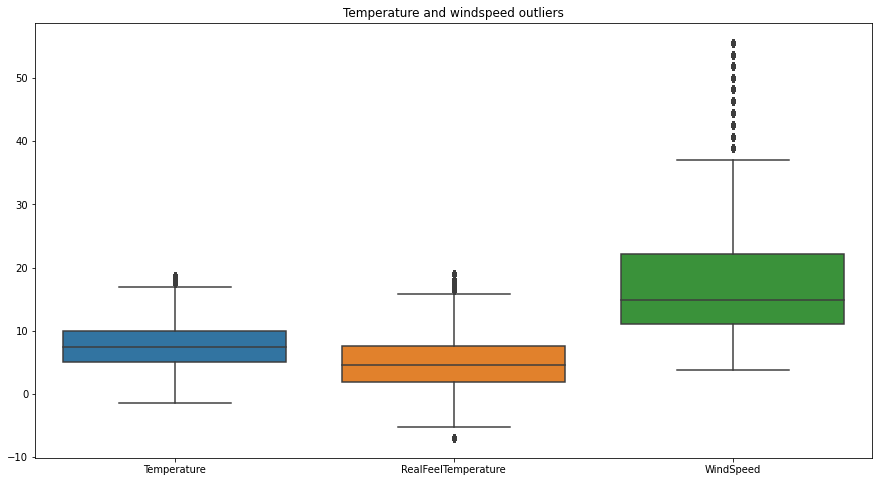

In [49]:
#can observe a few outliers in all features examined

fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=availability_table[['Temperature', 'RealFeelTemperature', "WindSpeed"]])
ax.set_title('Temperature and windspeed outliers')
plt.show()

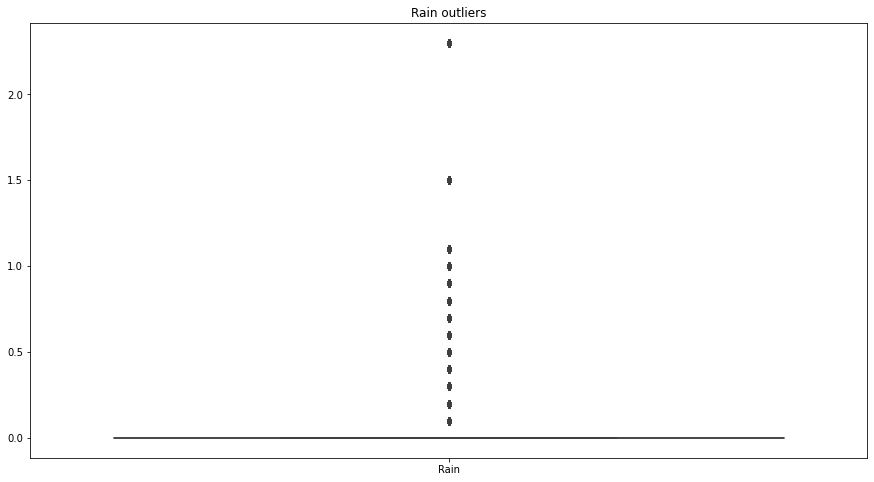

In [50]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=availability_table[["Rain"]])
ax.set_title('Rain outliers')
plt.show()

In [51]:
df = availability_table

In [52]:
# replacing outliers with median values
# code structure sourced from https://stackoverflow.com/questions/55268364/how-to-replace-outliers-with-median-in-pandas-dataframe


column_names = ['Temperature','RealFeelTemperature', "WindSpeed"]

for column in column_names:
    median = df[column].median()
    std = df[column].std()
    outliers = (df[column] - median).abs() > std
    df[outliers] = np.nan
    df[column].fillna(median, inplace=True)




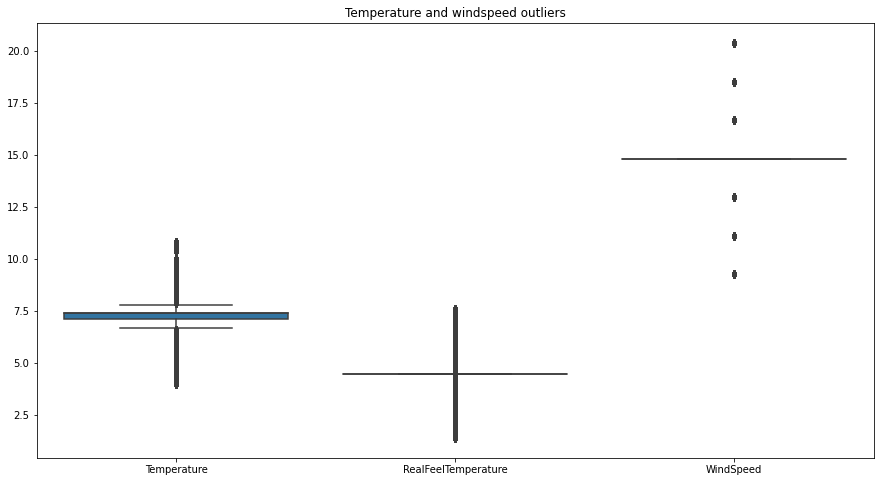

In [53]:
#All values now liw within the previous interquartile spread

fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=df[['Temperature', 'RealFeelTemperature', "WindSpeed"]])
ax.set_title('Temperature and windspeed outliers')
plt.show()

## Multilinear model for one station

In [65]:
### all features included

In [66]:
## Reduced number of features

In [67]:
availability_table.head()

,number,name,last_update,day,hour,available_bikes,bike_stands,percentage_available,DateTime,IconPhrase,HasPrecipitation,IsDaylight,Temperature,PrecipitationProbability,RealFeelTemperature,WindSpeed,RelativeHumidity,Rain,CloudCover
0,108,AVONDALE ROAD,2021-03-02 17:00:28,2,17,2,40,0.0500,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
1,13,FITZWILLIAM SQUARE WEST,2021-03-02 17:01:11,2,17,14,30,0.4667,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
2,43,PORTOBELLO ROAD,2021-03-02 17:00:31,2,17,6,30,0.2000,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
3,31,PARNELL STREET,2021-03-02 17:01:31,2,17,1,20,0.0500,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
4,87,COLLINS BARRACKS MUSEUM,2021-03-02 17:00:03,2,17,0,38,0.0000,2021-03-02T17:00:00+00:00,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46


In [68]:
availability_table = availability_table.drop(["name", "last_update", "DateTime"], axis=1)

In [69]:
df = availability_table.loc[availability_table['number'] == 13]
X = df.drop(["percentage_available","IconPhrase"], axis=1)
y = df["percentage_available"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

2.3801976340171086e-05
7.547715385230865e-10
2.7473105731298136e-05


In [74]:
average_mean_absolute= []
average_mean_squared= []
average_RSME= []
average_accuracy = []

for num in station_nums:
    df = availability_table.loc[availability_table['number'] == num]
    X = df.drop(["percentage_available","IconPhrase"], axis=1)
    y = df["percentage_available"]

    X_train, X_test, y_train, y_test = train_test_split(X,y)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)
    
    average_mean_absolute.append(metrics.mean_absolute_error(y_test,y_pred))
    average_mean_squared.append(metrics.mean_squared_error(y_test,y_pred))
    average_RSME.append(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
    average_accuracy.append(regr.score(X_train,y_train))
    
    print(f"Metrics for station number {num}")
    print(f"Mean absolute error: {metrics.mean_absolute_error(y_test,y_pred)}")
    print(f"Mean squared error: {metrics.mean_squared_error(y_test,y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}")
    print()

print("Average metrics")
print(f"Mean accuracy: {sum(average_accuracy) / len(average_accuracy)}")
print(f"Mean absolute error:{sum(average_mean_absolute) / len(average_mean_absolute)}")
print(sum(average_mean_squared) / len(average_mean_squared))
print(sum(average_RSME) / len(average_RSME))

Metrics for station number 2
Mean absolute error: 3.0514892897384203e-16
Mean squared error: 1.3990066365228277e-31
RMSE: 3.740329713438145e-16

Metrics for station number 3
Mean absolute error: 6.667821368865415e-16
Mean squared error: 7.0747986458088995e-31
RMSE: 8.411182227136028e-16

Metrics for station number 4
Mean absolute error: 3.930966950468193e-16
Mean squared error: 2.368352874174392e-31
RMSE: 4.866572586712739e-16

Metrics for station number 5
Mean absolute error: 7.053981182449622e-16
Mean squared error: 7.831380984656561e-31
RMSE: 8.849509017259975e-16

Metrics for station number 6
Mean absolute error: 8.0224710886297405e-16
Mean squared error: 9.328223253657552e-31
RMSE: 9.65827275120016e-16

Metrics for station number 7
Mean absolute error: 2.384770333092522e-05
Mean squared error: 7.858890933935163e-10
RMSE: 2.8033713514151426e-05

Metrics for station number 8
Mean absolute error: 2.3249181376430534e-05
Mean squared error: 7.416160899635996e-10
RMSE: 2.723262914159409

Mean absolute error: 3.0639595501312373e-16
Mean squared error: 1.3083977712232687e-31
RMSE: 3.617178142175567e-16

Metrics for station number 65
Mean absolute error: 6.753313468436812e-16
Mean squared error: 7.141002479696084e-31
RMSE: 8.450445242527807e-16

Metrics for station number 66
Mean absolute error: 4.915782766166552e-16
Mean squared error: 3.5723638386807933e-31
RMSE: 5.976925496173424e-16

Metrics for station number 67
Mean absolute error: 1.3920331781017455e-15
Mean squared error: 3.218396043552994e-30
RMSE: 1.793988863831934e-15

Metrics for station number 68
Mean absolute error: 5.035199754995618e-16
Mean squared error: 3.9983929952179185e-31
RMSE: 6.323284743879496e-16

Metrics for station number 69
Mean absolute error: 1.3693248579561384e-15
Mean squared error: 2.7863429885909426e-30
RMSE: 1.6692342521620334e-15

Metrics for station number 71
Mean absolute error: 2.7679429826895383e-16
Mean squared error: 1.2998109904486998e-31
RMSE: 3.605289156848171e-16

Metrics for 

## Multilinear for all stations

In [71]:
availability_table

,number,day,hour,available_bikes,bike_stands,percentage_available,IconPhrase,HasPrecipitation,IsDaylight,Temperature,PrecipitationProbability,RealFeelTemperature,WindSpeed,RelativeHumidity,Rain,CloudCover
0,108,2,17,2,40,0.0500,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
1,13,2,17,14,30,0.4667,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
2,43,2,17,6,30,0.2000,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
3,31,2,17,1,20,0.0500,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
4,87,2,17,0,38,0.0000,Partly sunny,0,1,6.8,0.0,5.1,11.1,84,0.0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193555,39,9,19,12,20,0.6000,Partly sunny w/ showers,1,1,4.9,51.0,1.4,11.1,67,0.3,40
1193556,83,9,19,20,40,0.5000,Partly sunny w/ showers,1,1,4.9,51.0,1.4,11.1,67,0.3,40
1193557,92,9,19,11,40,0.2750,Partly sunny w/ showers,1,1,4.9,51.0,1.4,11.1,67,0.3,40
1193558,21,9,19,6,30,0.2000,Partly sunny w/ showers,1,1,4.9,51.0,1.4,11.1,67,0.3,40


In [72]:
availability_table.dtypes

number                         int64
day                         category
hour                        category
available_bikes                int64
bike_stands                    int64
percentage_available         float64
IconPhrase                  category
HasPrecipitation            category
IsDaylight                  category
Temperature                  float64
PrecipitationProbability     float64
RealFeelTemperature          float64
WindSpeed                    float64
RelativeHumidity               int64
Rain                         float64
CloudCover                     int64
dtype: object

In [87]:
df = availability_table
X = df.drop(["percentage_available","IconPhrase"], axis=1)
y = availability_table["percentage_available"]

#splitting data out
X_train, X_test, y_train, y_test = train_test_split(X,y)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

y_pred = regr.predict(X_test)

print('Accuracy of the model :',regr.score(X_train,y_train))
print(f"Mean absolute error: {metrics.mean_absolute_error(y_test,y_pred)}")
print(f"Mean squared error: {metrics.mean_squared_error(y_test,y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}")

Intercept: 
 0.3507374038419386
Coefficients: 
 [ 2.89562261e-04  1.78063623e-04  5.23565612e-06  3.08559443e-02
 -1.13889406e-02 -2.57455920e-03  2.68869718e-03  8.18620844e-04
  2.60398020e-06 -7.53094954e-04  5.40961705e-05 -1.59533150e-06
  6.33668708e-04  2.99405169e-05]
Accuracy of the model : 0.9373049921974763
Mean absolute error: 0.037504790934926036
Mean squared error: 0.003046592408351154
RMSE: 0.055195945578920505


## Decision tree

In [75]:
from sklearn.tree import DecisionTreeRegressor

In [76]:
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)

In [80]:
df = availability_table
X = df.drop(["percentage_available","IconPhrase"], axis=1)
y = availability_table["percentage_available"]

#splitting data out
X_train, X_test, y_train, y_test = train_test_split(X,y)
dtr.fit(X_train,y_train)

dtr_score=dtr.score(X_train,y_train)
print('Accuracy of model :',dtr_score)


DecisionTreeRegressor(max_leaf_nodes=10)

Accuracy of model : 0.8917810068453556


In [84]:
from sklearn.ensemble import RandomForestRegressor
df = availability_table
X = df.drop(["percentage_available","IconPhrase"], axis=1)
y = availability_table["percentage_available"]

rf=RandomForestRegressor(n_estimators=20)

In [85]:
#Fit the trained model
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=20)

In [ ]:
X = df[["day","hour", "HasPrecipitation","IsDaylight","IconPhrase"]]
y = df["percentage_available"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
rfc.fit(X_train,y_train)

# Export model

# For model serialising

In [90]:
filename = 'finalized_model.sav'
pickle.dump(regr, open(filename, 'wb'))

In [88]:
import pickle

with open('model_pickle', 'wb') as f:
    pickle.dump(regr, f)

In [91]:
mp = pickle.load(open(filename, 'rb'))

In [ ]:
mp.predict()

In [ ]:
#for pickling process

from joblib import dump, load

dump(clf, 'filename.joblib')

In [ ]:
# pre-processsing step
#Drop null rows
#impute outliers
# Drop columns - 



# Define the Pipeline


pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(lowercase=True,
                                                      max_features=1000,
                                                      stop_words= ENGLISH_STOP_WORDS)),
                            ('model', LogisticRegression())])

## For model deserialising

In [ ]:
import pickle
import pandas as pd
import numpy as mnp
from sklearn.linear_model import LinearRegression

with open('model.pkl', 'rb') as handle:
    model = 
    
    oad(handle)
    
@route("/predict")
def predict(X_test):
    result = model.predict(X_test)
    return jsonify(result)
    